In [1]:
import task_similarity
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
import re
import collections

output_dir = '../output/'
results_dict_for_df = {key: [] for key in ['nhmms', 'nlatents', 'nsymbols', 'num_examples', 'num_tasks', 
                                           'batch_size', 'max_seq_length', 'seed', 'is_pt',
                                           'is_ft', 'div', 'ci', 'distance_matrix', 'title',
                                          'latent_concept_label', 'symbol_label', 'nvalues', 'nslots']}

# collect diversity coefficient results per GINC dataset
# into a dataframe |results_df|
for result_folder in os.listdir(output_dir):
    if 'ginc' in result_folder:
        file_dir = os.path.join(output_dir, result_folder)
        regex = "ginc_nhmms([0-9]+)_nsymbols([0-9]+)_([0-9]+)tasks_bs([0-9]+)_gpt2_maxseqlen([0-9]+)_seed([0-9]+)_([a-zA-Z]+)_([a-zA-Z]+)"
        match = re.search(regex, result_folder)
        num_ex = 1000
        nvalues = 10
        nslots = 10
        if match is None: # search num ex > 1000
            regex = "ginc_nhmms([0-9]+)_nsymbols([0-9]+)_nex([0-9]+)_([0-9]+)tasks_bs([0-9]+)_gpt2_maxseqlen([0-9]+)_seed([0-9]+)_([a-zA-Z]+)_([a-zA-Z]+)"
            match = re.search(regex, result_folder)
            if match is None: # search nvalues and nslots
                regex = "ginc_nhmms([0-9]+)_nsymbols([0-9]+)_nvalues([0-9]+)_nslots([0-9]+)_([0-9]+)tasks_bs([0-9]+)_gpt2_maxseqlen([0-9]+)_seed([0-9]+)_([a-zA-Z]+)_([a-zA-Z]+)"
                match = re.search(regex, result_folder)
                nhmms, nsymbols, nvalues, nslots, tasks, bs, maxseqlen, seed, is_pt, is_ft = match.groups()
            else:
                nhmms, nsymbols, num_ex, tasks, bs, maxseqlen, seed, is_pt, is_ft = match.groups()
        else:
            nhmms, nsymbols, tasks, bs, maxseqlen, seed, is_pt, is_ft = match.groups()
        bs, is_pt, is_ft = int(bs), is_pt == 'pt', is_ft == 'ft'
        #print(nhmms, nsymbols, tasks, bs, maxseqlen, seed, is_pt, is_ft)
        
        results_file = os.path.join(file_dir, 'results.npy')
        if os.path.isfile(results_file):
            results_dict = np.load(results_file, allow_pickle=True).item()
            div, ci = task_similarity.stats_of_distance_matrix(results_dict['distance_matrix'])

            results_dict_for_df['nhmms'].append(int(nhmms))
            results_dict_for_df['nlatents'].append(int(int(nhmms)/2))
            results_dict_for_df['nsymbols'].append(int(nsymbols))
            results_dict_for_df['nvalues'].append(int(nvalues))
            results_dict_for_df['nslots'].append(int(nslots))
            results_dict_for_df['num_examples'].append(int(num_ex))
            results_dict_for_df['num_tasks'].append(int(tasks))
            results_dict_for_df['batch_size'].append(int(bs))
            results_dict_for_df['max_seq_length'].append(int(maxseqlen))
            results_dict_for_df['seed'].append(int(seed))
            results_dict_for_df['is_pt'].append(int(is_pt))
            results_dict_for_df['is_ft'].append(int(is_ft))
            results_dict_for_df['div'].append(div)
            results_dict_for_df['ci'].append(ci)
            results_dict_for_df['distance_matrix'].append(results_dict['distance_matrix'])
            if nhmms == '2':
                results_dict_for_df['title'].append(f'{int(nhmms)//2} latent concept, {nsymbols} symbols')
                results_dict_for_df['latent_concept_label'].append(f'{int(nhmms)//2} latent concept')
            else:
                results_dict_for_df['title'].append(f'{int(nhmms)//2} latent concepts, {nsymbols} symbols')
                results_dict_for_df['latent_concept_label'].append(f'{int(nhmms)//2} latent concepts')
            results_dict_for_df['symbol_label'].append(f'{nsymbols} symbols')
results_df = pd.DataFrame.from_dict(results_dict_for_df)
results_df = results_df.sort_values(['nhmms', 'nsymbols', 'num_examples', 'is_pt']).reset_index(drop=True)

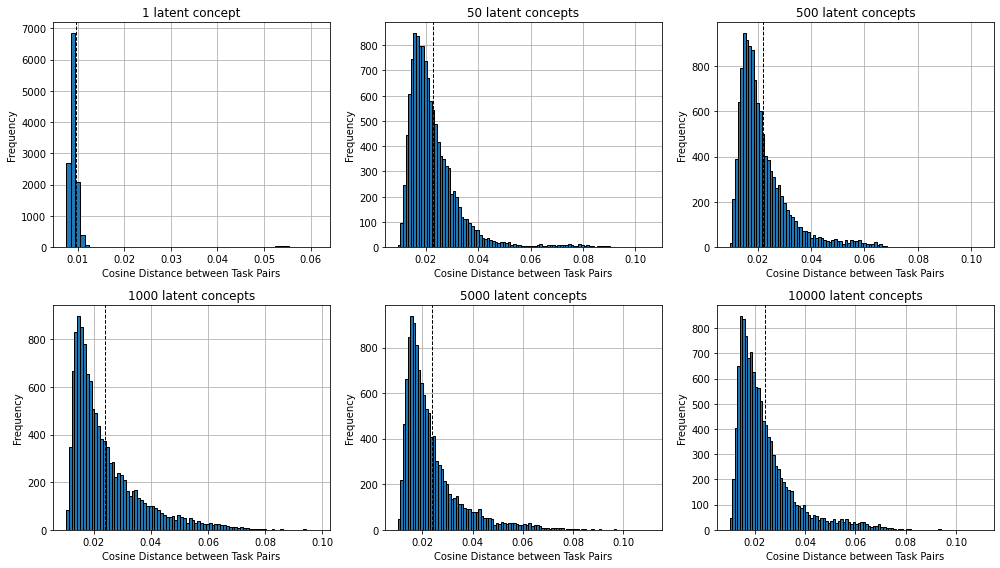

In [145]:
plot_df = results_df[(results_df['nvalues']==10) & (results_df['nslots']==10) & (results_df['num_examples']==1000) & (results_df['is_pt'] == 1)]
filter_df = plot_df[(plot_df['nsymbols']==50) & (plot_df['nlatents'].isin([1,50,500,1000,5000,10000]))]
distance_matrix_lst = filter_df['distance_matrix'].values
hist_title_lst = filter_df['latent_concept_label'].values
task_similarity_for_plotting.plot_multi_histogram_of_distances(distance_matrix_lst, 
                                                               hist_title_lst, 
                                                               save_file=False,
                                                               #main_title='Distribution of Task2Vec Distances', 
                                                               show_plot=True,
                                                               bins_width=0.001,
                                                               num_cols=3,
                                                               figsize=(14, 8))

In [24]:
# view diversity coefficients for specific number of HMMs vs. vocab size
plot_df.pivot(index='nhmms', columns='nsymbols', values='div')

nsymbols,50,100,150,250,500,1000,5000,10000,20000
nhmms,,,,,,,,,
2,0.009559,0.009648,0.011009,0.009050,0.012130,0.017384,0.036055,0.044037,0.061728
10,0.013784,0.012664,0.015823,0.012339,0.015583,0.022022,0.046201,0.055533,0.076851
20,0.017861,0.016140,0.015226,NaN,NaN,NaN,NaN,NaN,NaN
50,0.019251,0.017201,0.015680,NaN,NaN,NaN,NaN,NaN,NaN
100,0.022858,0.021387,0.018883,0.014263,0.018380,0.024720,0.045983,0.054762,0.076207
200,0.023493,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
500,0.023201,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1000,0.022157,0.020676,0.018647,0.013977,0.018264,0.024513,NaN,NaN,0.073546
2000,0.024125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


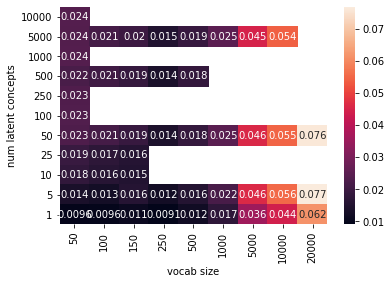

In [9]:
pivot_df = plot_df.rename({'nlatents': 'num latent concepts', 'nsymbols': 'vocab size'}, axis=1).pivot(index='num latent concepts', columns='vocab size', values='div')
pivot_df.sort_index(level=0, ascending=False, inplace=True) 
_ = sns.heatmap(pivot_df, annot=True)

0.9931744498127395


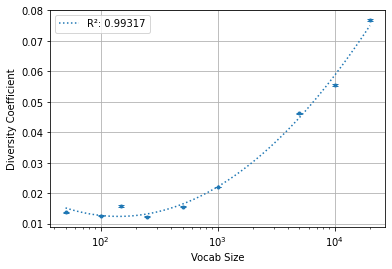

In [31]:
from scipy.optimize import curve_fit
from scipy.stats import linregress

_DIGITS = [
    "\N{superscript zero}",
    "\N{superscript one}",
    "\N{superscript two}",
    "\N{superscript three}",
    "\N{superscript four}",
    "\N{superscript five}",
    "\N{superscript six}",
    "\N{superscript seven}",
    "\N{superscript eight}",
    "\N{superscript nine}"
]

def stringify_exponent(n, m):
    superscripted = "".join(_DIGITS[int(d)] for d in str(m))
    return f"{n}{superscripted}"

def fit(x_values, y):
    coeffs = np.polyfit(x_values, y, deg=2)
    # Evaluate polynomial at given x values 
    y_pred = np.polyval(coeffs,x_values)
    # Calculate residual sum of squares (RSS) and total sum of squares (TSS)
    rss = np.sum((y-y_pred)**2)
    tss = np.sum((y-np.mean(y))**2)
    # Calculate R-squared as 1 - RSS/TSS 
    r_squared = 1 - rss/tss
    print(r_squared)
    return coeffs, r_squared

if False:
    pivot_df = plot_df[plot_df['nsymbols']==50]
    x = pivot_df['nlatents']
    xlabel = "Num Latent Concepts"    
else:
    pivot_df = plot_df[plot_df['nlatents']==5]
    x = pivot_df['nsymbols']
    xlabel = "Vocab Size"
y = pivot_df['div']
ci = pivot_df['ci']

do_log = plot_curve = True

if do_log:
    x_values = np.log10(x)
else:
    x_values = x

## Compute R^2
coeffs, r_squared = fit(x_values, y)

plt.errorbar(x=x, y=y, yerr=ci, capsize=3, ls='none',color='C0', fmt='.')
plt.grid(True)

if plot_curve:
    x_line = np.arange(min(x), max(x))
    y_line = np.polyval(coeffs,np.log10(x_line))
    plt.plot(x_line, y_line, ":", color='C0', label=stringify_exponent("R", 2)+ f": {r_squared:.5f}")
    plt.legend()
plt.xlabel(xlabel)
plt.ylabel("Diversity Coefficient")
if do_log:
    plt.xscale("log")

0.9931744498127395
0.9836672606895082


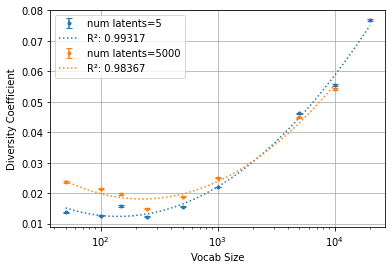

In [69]:
plot_num_latents = False
do_log = plot_curve = True

if plot_num_latents: # plot div coeff vs. num latent concepts
    lst = [50, 150]
    col = 'nsymbols'
    xcol = 'nlatents'
    pivot_df = plot_df[plot_df[col].isin(lst)]
    label = 'vocab size='
    xlabel = "Num Latent Concepts"    
else: # plot div coeff vs. vocab size
    lst = [5, 5000]
    col = 'nlatents'
    xcol = 'nsymbols'
    pivot_df = plot_df[plot_df[col].isin(lst)]
    label = 'num latents='
    xlabel = "Vocab Size"

for val, color in zip(lst, ['C0','C1']):
    filter_df = pivot_df[pivot_df[col]==val]
    x = filter_df[xcol]
    y = filter_df['div']
    ci = filter_df['ci']
    
    if do_log:
        x_values = np.log10(x)
    else:
        x_values = x
    
    coeffs, r_squared = fit(x_values, y)
    plt.errorbar(x=x, y=y, yerr=ci, capsize=3, color=color, ls='none',fmt='.', label=label+str(val))
    if plot_curve:
        x_line = np.arange(min(x), max(x))
        y_line = np.polyval(coeffs,np.log10(x_line))
        plt.plot(x_line, y_line, ":", color=color, label=stringify_exponent("R", 2)+ f": {r_squared:.5f}")

handles, labels = plt.gca().get_legend_handles_labels()
order = [2,0,3,1]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order]) 
plt.xlabel(xlabel)
plt.ylabel("Diversity Coefficient")
plt.grid(True)
if do_log:
    plt.xscale("log")

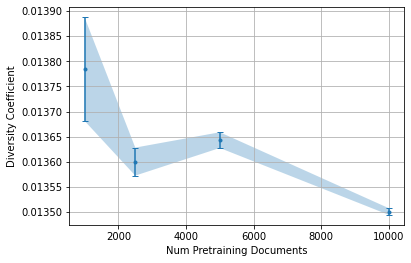

In [155]:
# plot diversity coeff vs. number of pretraining documents
numex_df = results_df[(results_df['nvalues']==10) & (results_df['nslots']==10) & (results_df['nlatents']==5) & (results_df['nsymbols'] == 50) & (results_df['is_pt'] == 1)]
filter_df = numex_df
plt.errorbar(x=filter_df['num_examples'].astype(int), y=filter_df['div'], yerr=filter_df['ci'], 
             fmt='.', capsize=3, ls='none')
plt.fill_between(x=filter_df['num_examples'].astype(int), y1=filter_df['div'] - filter_df['ci'], 
                 y2=filter_df['div'] + filter_df['ci'], alpha=0.3)
plt.grid(True)
plt.xlabel("Num Pretraining Documents")
plt.ylabel('Diversity Coefficient')
plt.show()

In [23]:
numex_df.pivot(index='nlatents', columns='num_examples', values='div')

num_examples,1000,2500,5000,10000
nlatents,,,,
5,0.013784,0.013601,0.013643,0.013501


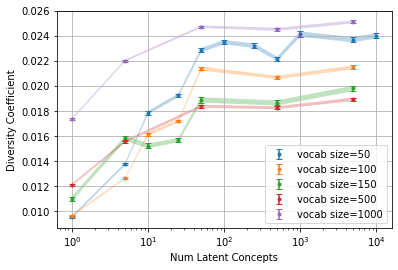

In [152]:
# plot div coeff vs. num latent concepts with 95% confidence interval
import pandas as pd
import seaborn as sns

def get_distance_values(distance_matrix):
    triu = np.triu(distance_matrix)
    triu = triu[triu != 0.0]
    return triu.flatten()
    
df = plot_df.copy()
for num_symbols in [50,100,150,500,1000]:
    filter_df = df[df['nsymbols']==num_symbols]
    plt.errorbar(x=filter_df['nlatents'].astype(int), y=filter_df['div'], yerr=filter_df['ci'], 
                 label=f'vocab size={num_symbols}', fmt='.', capsize=3, ls='none')#,color='C0')
    plt.fill_between(x=filter_df['nlatents'].astype(int), y1=filter_df['div'] - filter_df['ci'], 
                     y2=filter_df['div'] + filter_df['ci'], alpha=0.3)
plt.grid(True)
plt.legend()
plt.xlabel("Num Latent Concepts")
plt.ylabel('Diversity Coefficient')
plt.xscale("log")
plt.show()

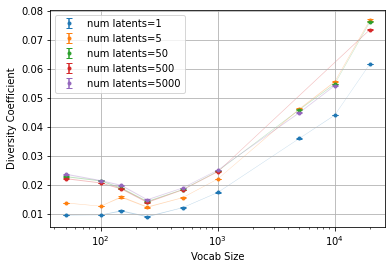

In [98]:
# plot div coeff vs. vocab size with 95% confidence interval
df = plot_df.copy()
for nhmm in [2, 10, 100, 1000, 10000]:
    filter_df = df[df['nhmms']==nhmm]
    plt.errorbar(x=filter_df['nsymbols'].astype(int), y=filter_df['div'], yerr=filter_df['ci'], 
                 label=f'num latents={nhmm//2}', fmt='.', capsize=3, ls='none')#,color='C0')
    plt.fill_between(x=filter_df['nsymbols'].astype(int), y1=filter_df['div'] - filter_df['ci'], 
                     y2=filter_df['div'] + filter_df['ci'], alpha=0.3)
plt.grid(True)
plt.legend()
plt.xlabel("Vocab Size")
plt.ylabel('Diversity Coefficient')
plt.xscale("log")
plt.show()